# Zaman Serisi Analizi (Madenciliği)

Zaman içerisinde gelişen olayların ve işlemlerin analizi için kullanılan tekniklerdir.
https://productphilosophy.com/zaman-serisi-analizi/


## TIME-SERIES DECOMPOSITON (Zaman Serisinin Ayrıştırılması)
### Trend + Mevsimsel + Döngüsel bileşenlerine ayrıştırma

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose # statsmodels kütüphanesi yok ise "pip install statsmodels"

In [12]:
df = pd.read_csv("https://raw.githubusercontent.com/yasarkucukefe/YBS_405/main/data/AirPassengers.csv", parse_dates=["Month"], index_col=['Month'])

In [13]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


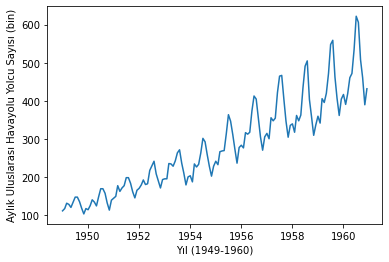

In [17]:
# Plot data
fig, ax = plt.subplots()
plt.plot(df)
plt.xlabel('Yıl (1949-1960)')
plt.ylabel('Aylık Uluslarası Havayolu Yolcu Sayısı (bin)')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

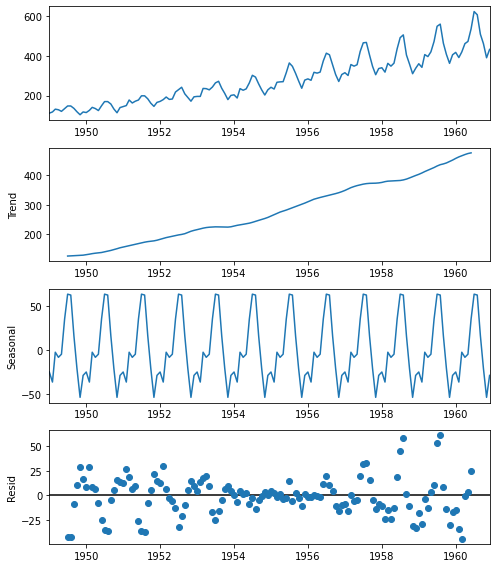

In [18]:
# Zaman serisinin ayrıştırılması
plt.rcParams['figure.figsize'] = [7, 8]

sd = seasonal_decompose(df, period=12).plot()

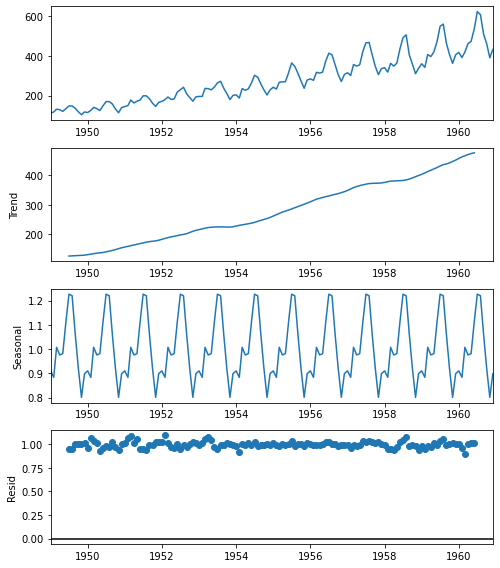

In [19]:
# Yolcu sayısı yıllara göre arttığı için sabit bir mevsimsel bileşen sorun teşkil edebilir.
# Çözüm olarak, model olarak "multiplicative" trend kullanılmalıdır.

sd = seasonal_decompose(df, model="multiplicative").plot()

## ARIMA: Autoregressive Integrated Moving Average

Python library: pmdarima <br>pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima.arima import auto_arima

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/yasarkucukefe/YBS_405/main/data/AirPassengers.csv", parse_dates=["Month"], index_col=['Month'])

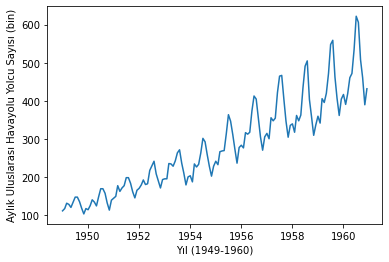

In [4]:
# Plot data
fig, ax = plt.subplots()
plt.plot(df)
plt.xlabel('Yıl (1949-1960)')
plt.ylabel('Aylık Uluslarası Havayolu Yolcu Sayısı (bin)')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

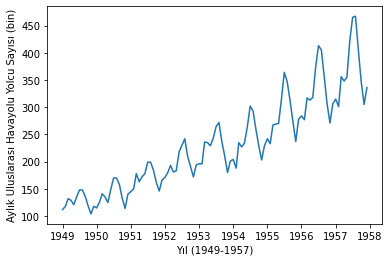

In [7]:
# Problem: 1958-1960 yıllarında gerçekleşecek yolcu sayısını 1957 Aralık ayına kadar olan veriyi kullanarak tahmin etmek
# Veri setinin ayrılması
trn = df.loc[df.index < '1958-01-01']
tst = df.loc[df.index >= '1958-01-01']
# Plot eğitim verisi
fig, ax = plt.subplots()
plt.plot(trn)
plt.xlabel('Yıl (1949-1957)')
plt.ylabel('Aylık Uluslarası Havayolu Yolcu Sayısı (bin)')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

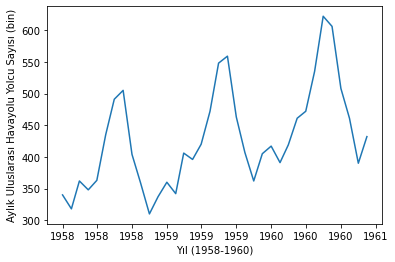

In [9]:
# Plot test verisi (ARIMA ile yapılan tahminleri kontrol edeceğimiz veri)
fig, ax = plt.subplots()
plt.plot(tst)
plt.xlabel('Yıl (1958-1960)')
plt.ylabel('Aylık Uluslarası Havayolu Yolcu Sayısı (bin)')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

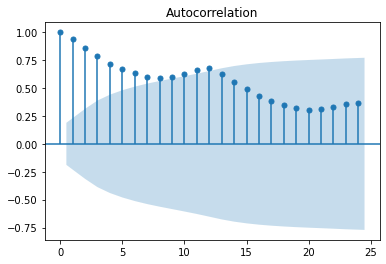

In [10]:
# 1. adım
# ARIMA tekniğini kullanabilmek için verinin "durağan olmaması" gerekir (non-stationary). 
trn_acf = plot_acf(trn, lags=24)


In [11]:
# Doğrusal Regresyon (Linear Regression)
lr = sm.OLS(endog=trn["#Passengers"],exog=sm.add_constant(np.arange(1,1+trn.shape[0]))).fit()
print(lr.summary)

<bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x000002883E8EAD30>>


In [12]:
y_hat = lr.fittedvalues

In [13]:
y_ci = lr.get_prediction().conf_int(alpha=0.05)

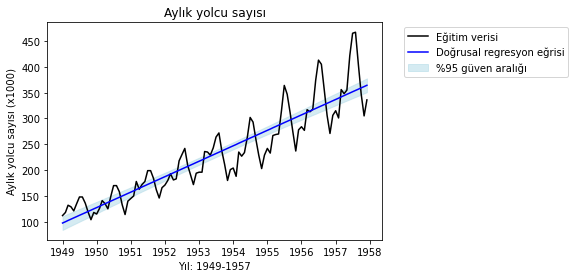

In [14]:
fig, ax = plt.subplots()
plt.xlabel('Yıl: 1949-1957')
plt.ylabel('Aylık yolcu sayısı (x1000)')
plt.title('Aylık yolcu sayısı')
plt.plot(trn, color='black', label='Eğitim verisi')
plt.plot(y_hat, color='blue', label='Doğrusal regresyon eğrisi')
plt.fill_between(y_hat.index, y_ci[:,0],y_ci[:,1], color='lightblue', alpha=0.5, label='%95 güven aralığı')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

## ARIMA Modeli

In [15]:
auto_arima_model = auto_arima(trn, m=12, with_intercept=False, suppress_warnings=True)
print(auto_arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -350.001
Date:                            Fri, 26 Nov 2021   AIC                            704.001
Time:                                    13:03:39   BIC                            709.109
Sample:                                         0   HQIC                           706.065
                                            - 108                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2411      0.091     -2.648      0.008      -0.420      -0.063
sigma2        92.7499     13.439   

In [16]:
auto_arima_model.order

(1, 1, 0)

In [17]:
auto_arima_model.seasonal_order

(0, 1, 0, 12)

In [18]:
# TEST MODEL
# Eğitim verisi kullanarak en iyi modeli fit
auto_arima_model.fit(trn)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [19]:
arima_tahmin = auto_arima_model.predict(n_periods=36, alpha=0.05, return_conf_int=True)

In [21]:
y_tahmin = pd.Series(arima_tahmin[0], index=tst.index)

In [22]:
y_tahmin_lb, y_tahmin_up = arima_tahmin[1][:,0], arima_tahmin[1][:,1]

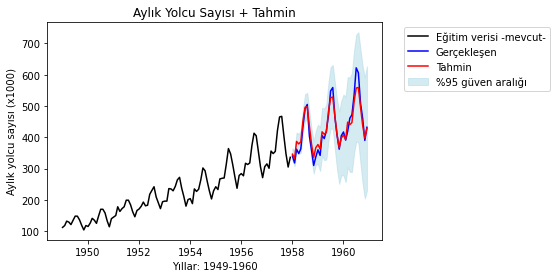

In [23]:
# Grafik
fig, ax = plt.subplots()
plt.xlabel("Yıllar: 1949-1960")
plt.ylabel('Aylık yolcu sayısı (x1000)')
plt.title('Aylık Yolcu Sayısı + Tahmin')
plt.fill_between(tst.index, y_tahmin_lb, y_tahmin_up, color='lightblue', alpha=0.5, label='%95 güven aralığı')
plt.plot(trn, color='black', label='Eğitim verisi -mevcut-')
plt.plot(tst, color='blue', label='Gerçekleşen')
plt.plot(y_tahmin, color='red', label='Tahmin')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# MLP: Multi Layer Perceptron
## Yapay Zeka
https://en.wikipedia.org/wiki/Multilayer_perceptron

In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Read data
df = pd.read_csv("https://raw.githubusercontent.com/yasarkucukefe/YBS_405/main/data/AirPassengers.csv", parse_dates=["Month"], index_col=['Month'])

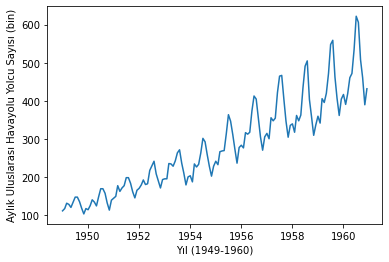

In [26]:
# Plot data
fig, ax = plt.subplots()
plt.plot(df)
plt.xlabel('Yıl (1949-1960)')
plt.ylabel('Aylık Uluslarası Havayolu Yolcu Sayısı (bin)')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

In [28]:
# Veriye yeni şekil (reshape)
k = 12
Z = []
for i in range(k+1, df.shape[0]+1):
    Z.append(df.iloc[(i-k-1):i, 0])
Z = np.array(Z)

In [29]:
Z.shape

(132, 13)

In [30]:
Z[0]

array([112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115],
      dtype=int64)

In [47]:
# Verinin eğitim ve test olarak ikiye ayrılması
split = np.int(0.8 * Z.shape[0])
Z_train, Z_test = Z[:split, :], Z[split:, :]

In [48]:
Z_test.shape

(27, 13)

In [49]:
# Scaling
scaler = StandardScaler().fit(Z_train)
Z_train = scaler.transform(Z_train)
Z_test = scaler.transform(Z_test)

In [50]:
# Özellik (feature) ve sonuc (target) değerleri (X, y)
X_train, y_train = Z_train[:, :-1], Z_train[:, -1]
X_test, y_test = Z_test[:, :-1], Z_test[:, -1]

In [54]:
# Fit MLP with %20 validation set
split_ = np.int(0.8 * X_train.shape[0])
X_train_, y_train_ = X_train[:split_,:], y_train[:split_]
X_valid_, y_valid_ = X_train[split_:,:], y_train[split_:]

In [55]:
print(X_train_.shape, y_train_.shape)

(84, 12) (84,)


In [56]:
print(X_valid_.shape, y_valid_.shape)

(21, 12) (21,)


In [57]:
# Validation loss function (Mean Square Error kullanarak)
def validation_loss(hidden_neurons):
    mlp = MLPRegressor(hidden_layer_sizes=(hidden_neurons,), max_iter=500, random_state=1, shuffle=False)
    mlp.fit(X_train_, y_train_)
    return mean_squared_error(y_valid_, mlp.predict(X_valid_))

In [60]:
params = [10, 25, 30, 50, 75]
mse = [validation_loss(p) for p in params]

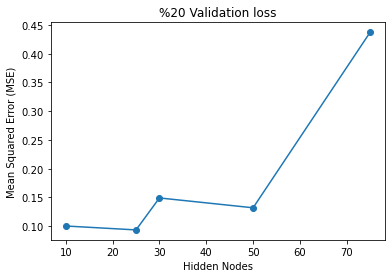

In [62]:
# Hidden node sayısına bağlı olarak hata grafiği
fig, ax = plt.subplots()
plt.xlabel('Hidden Nodes')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('%20 Validation loss')
plt.plot(params, mse, '-o')

In [63]:
# MLP Hidden Node sayısı 25 alınabilir. Çünkü bu değer için MSE en düşük
mlp = MLPRegressor(hidden_layer_sizes=(25,), max_iter=500, random_state=1, shuffle=False)

In [64]:
mlp.fit(X_train, y_train) # MLP fit with training data

MLPRegressor(hidden_layer_sizes=(25,), max_iter=500, random_state=1,
             shuffle=False)

In [65]:
y_pred = mlp.predict(X_test)  # Forecast

In [66]:
print(y_pred)

[1.41200889 1.08015276 0.81504007 1.07116898 1.04832286 0.93673313
 1.4048666  1.60609879 2.5581707  3.05044303 3.21923548 2.44984189
 1.77291831 1.32871263 1.07618167 1.47459932 1.41350495 1.36704686
 1.58474291 2.21889429 3.06446214 3.74038767 4.0371449  2.93046894
 2.15529939 1.95392346 1.64846274]


In [67]:
# Verinin ilk ölçeğine döndürülmesi
y_test_ = scaler.inverse_transform(np.hstack([X_test, y_test.reshape(-1,1)]))[:, -1]
y_pred_ = scaler.inverse_transform(np.hstack([X_test, y_pred.reshape(-1,1)]))[:, -1]

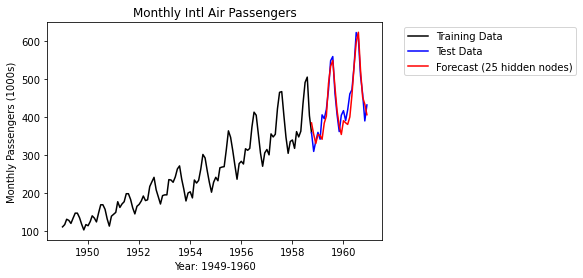

In [68]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(df.iloc[:(k + len(y_train) + 1), :], color='black', label='Training Data')
plt.plot(pd.Series(y_test_, index=df.index[-len(y_test):]), color='blue', label='Test Data')
plt.plot(pd.Series(y_pred_, index=df.index[-len(y_test):]), color='red', label='Forecast (25 hidden nodes)')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))